# Data import

In [61]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable


In [64]:
!pip install plotly --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
import datetime as dt
import matplotlib.font_manager as fm
import random
import holidays
import itertools

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from plotnine import *
from pathlib import Path
from matplotlib import gridspec
from scipy import stats

import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px


In [2]:
fm.get_fontconfig_fonts()
font_location = 'C:\\WINDOWS\\Fonts\\malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2582751676.py:1: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.


In [3]:
FILES_DIR = '../files/'
log_df = pd.read_csv(FILES_DIR + 'log_csv.csv')
bidding_df = pd.read_csv(FILES_DIR + 'bidding_results.csv')

In [4]:
log = log_df.copy()
bidding = bidding_df.copy()

# Null Value Processing

In [5]:
# column describe 
def descriptive_info(log):
    number_of_cells = log.count(axis=0, level=None, numeric_only=False)
    print('Total number of cells the datafile has: \n' + str(number_of_cells))
    print('\n')
    print('Printing descriptive statistics...\n\n', log.describe())

descriptive_info(log)

Total number of cells the datafile has: 
Unnamed: 0         5659541
uid                5473228
action_type        5659541
category1          5659541
category2          5659541
category3          4879535
collect_time       5659541
geoip_city_name    5242509
useragent_os       5659541
viewrate           5657112
viewtime           5659541
dtype: int64


Printing descriptive statistics...

          Unnamed: 0      viewrate      viewtime
count  5.659541e+06  5.657112e+06  5.659541e+06
mean   2.829770e+06  7.677686e+01  5.126022e+04
std    1.633769e+06  4.221447e+01  5.810345e+05
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.414885e+06  1.000000e+02  8.940000e+02
50%    2.829770e+06  1.000000e+02  1.010400e+04
75%    4.244655e+06  1.000000e+02  4.800500e+04
max    5.659540e+06  1.000000e+02  8.636989e+07


In [6]:
# 서울과 경기도는 시, 구와 중복 데이터이기 때문에 drop한다
log_null_ts = log.copy()
drop_city = log_null_ts[log_null_ts['geoip_city_name'] != 'Seoul']
drop_city = drop_city[drop_city['geoip_city_name'] != 'Gyeonggi-do']

drop_city.isnull().sum().sort_values(ascending=False)

category3          643126
geoip_city_name    417032
uid                132162
viewrate             1722
Unnamed: 0              0
action_type             0
category1               0
category2               0
collect_time            0
useragent_os            0
viewtime                0
dtype: int64

In [7]:
# null값들을 un_** 으로 채워서 확인해보기
log_drop_null = drop_city
log_drop_null['geoip_city_name'].fillna('un_city_name', inplace = True)
log_drop_null['category3'].fillna('un_category', inplace = True)
log_drop_null['uid'].fillna('un_name', inplace = True)
log_drop_null.dropna(axis = 0, inplace = True)
print(log_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

Unnamed: 0         0
uid                0
action_type        0
category1          0
category2          0
category3          0
collect_time       0
geoip_city_name    0
useragent_os       0
viewrate           0
viewtime           0
dtype: int64


In [8]:
log_drop_null

,Unnamed: 0,uid,action_type,category1,category2,category3,collect_time,geoip_city_name,useragent_os,viewrate,viewtime
0,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,2022-12-29 17:29:02,Seongnam-si,Windows,100.0,80033
1,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,2022-12-29 12:56:38,Yongin-si,Windows,0.0,0
3,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,2022-12-29 17:54:30,Gwangmyeong-si,Windows,0.0,0
4,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,2022-12-29 18:45:05,Jongno-gu,Mac OS X,100.0,1238
5,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,2022-12-29 17:53:11,Incheon,Windows,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
5659533,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,2022-12-29 12:45:14,Gangnam-gu,Android,100.0,6054
5659534,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,2022-12-28 15:40:29,Songpa-gu,Windows,100.0,10006
5659537,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,2022-12-28 14:30:09,Jinju,Windows,0.0,0
5659538,5659538,diRXdmN49dUABrVo,View,가구,테이블·식탁·책상,식탁,2022-12-29 12:45:13,Gunpo,Android,100.0,47217


# Time Series

In [9]:
# 날짜 데이터 데이트타임으로 바꾸기
def _trans_date_time(log):
    log.index = pd.to_datetime(log['collect_time'], infer_datetime_format=True)
    log.drop('collect_time', axis=1, inplace=True)
    return log

_trans_date_time(log_drop_null)

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime
collect_time,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2022-12-29 12:45:14,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,Gangnam-gu,Android,100.0,6054
2022-12-28 15:40:29,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,Songpa-gu,Windows,100.0,10006
2022-12-28 14:30:09,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,Jinju,Windows,0.0,0


In [10]:
log_drop_null["Hour"] = log_drop_null.index.hour
log_drop_null['Minute'] = log_drop_null.index.minute

In [11]:
basket_hour = log_drop_null.loc[log_drop_null['action_type'] == 'Basket']
basket_hour

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime,Hour,Minute
collect_time,,,,,,,,,,,,
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0,12,56
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0,17,53
2022-12-29 11:00:45,32,tqzAY2DMOxsADYls,Basket,패브릭,러그·카페트,극세사·단모러그,Mapo-gu,Windows,0.0,0,11,0
2022-12-29 11:48:43,87,Dj8PAV/W7asADnq1,Basket,가구,소파,일반소파,Gangnam-gu,Windows,0.0,0,11,48
2022-12-29 18:01:46,129,eZVNKmBQMGcAAZPC,Basket,가구,행거·옷장,행거,Mokpo,Windows,0.0,0,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28 18:24:24,5659340,c37ZeGLn6YoACX9Y,Basket,가전·디지털,주방가전,커피메이커·머신,Incheon,Windows,0.0,0,18,24
2022-12-28 17:20:48,5659363,cxWkMmOS27MAA/zz,Basket,가전·디지털,주방가전,오븐·전자레인지,Bucheon-si,Windows,0.0,0,17,20
2022-12-29 10:27:10,5659444,0/15ImMIN1MAA8Hj,Basket,주방용품,주방수납·정리,주방선반·정리대,Gwangju,Windows,0.0,0,10,27


In [12]:
basket_hour['Hour'].value_counts(normalize=True)

15    0.083965
14    0.081647
13    0.081536
11    0.080453
16    0.078377
10    0.070698
17    0.061447
12    0.061088
9     0.043931
21    0.042579
22    0.041862
23    0.040144
20    0.037819
0     0.036087
18    0.035611
19    0.033749
1     0.023545
2     0.016757
8     0.016253
3     0.010576
4     0.006271
7     0.005747
5     0.005416
6     0.004443
Name: Hour, dtype: float64

In [13]:
log_drop_null['time_1'] = np.where((log_drop_null['Hour'] >= 10)&(log_drop_null["Hour"].values <= 17) , "1","0" )
log_time1 = log_drop_null.loc[log_drop_null["time_1"] == "1"]
log_time1['useragent_os'].value_counts(normalize=True)

Windows      7.674684e-01
Android      1.117415e-01
iOS          7.020231e-02
Mac OS X     4.871286e-02
Linux        1.468055e-03
Chrome OS    1.961608e-04
Other        1.106851e-04
CentOS       3.820802e-05
Ubuntu       3.545074e-05
Tizen        2.520942e-05
Fedora       7.877942e-07
FreeBSD      3.938971e-07
Name: useragent_os, dtype: float64

In [14]:
log_drop_null['time_2'] = np.where((log_drop_null['Hour'] >= 21) , "1","0" )
log_time2 = log_drop_null.loc[log_drop_null["time_2"] == "1"]
log_time2['useragent_os'].value_counts(normalize=True)

Windows      0.474668
Android      0.270808
iOS          0.171572
Mac OS X     0.079242
Linux        0.003115
Chrome OS    0.000220
Other        0.000172
Ubuntu       0.000096
Tizen        0.000055
CentOS       0.000052
Name: useragent_os, dtype: float64

In [15]:
basket_hour["time_1"] = np.where((basket_hour['Hour'] >= 10)&(basket_hour["Hour"].values <= 17) , "1","0" )
basket_time1 = basket_hour.loc[basket_hour["time_1"] == "1"]
basket_time1['useragent_os'].value_counts(normalize=True)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2322396749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Windows      0.925649
Mac OS X     0.070080
iOS          0.002084
Linux        0.001209
Android      0.000863
Chrome OS    0.000115
Name: useragent_os, dtype: float64

In [16]:
basket_hour["time_2"] = np.where((basket_hour['Hour'] >= 21) , "1","0" )
basket_time2 = basket_hour.loc[basket_hour["time_2"] == "1"]
basket_time2['useragent_os'].value_counts(normalize=True)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\241644529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Windows      0.844676
Mac OS X     0.136552
iOS          0.008638
Linux        0.007309
Android      0.002160
Chrome OS    0.000498
Ubuntu       0.000111
Tizen        0.000055
Name: useragent_os, dtype: float64

In [17]:
non_basket_hour = log_drop_null.loc[log_drop_null['action_type'] != 'Basket']
non_basket_hour

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime,Hour,Minute,time_1,time_2
collect_time,,,,,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033,17,29,1,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0,17,54,1,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238,18,45,0,0
2022-12-29 09:13:14,6,Adwku2KoPCwAANbw,View,노하우,꾸미기팁,un_category,Gwanak-gu,Windows,100.0,37161,9,13,0,0
2022-12-29 15:32:12,7,tOQhrWGfQcAACo9B,View,가구,테이블·식탁·책상,책상,Gangnam-gu,Windows,100.0,8483,15,32,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28 15:20:28,5659531,fG9bBGOiwtgAAuZu,Highlight,조명,형광등·조명부속품,전구·형광등,Cheonan,Windows,0.0,0,15,20,1,0
2022-12-29 12:45:14,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,Gangnam-gu,Android,100.0,6054,12,45,1,0
2022-12-28 15:40:29,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,Songpa-gu,Windows,100.0,10006,15,40,1,0


In [18]:
non_basket_hour["time_1"] = np.where((non_basket_hour['Hour'] >= 10)&(non_basket_hour["Hour"].values <= 17) , "1","0" )
non_basket_time1 = non_basket_hour.loc[non_basket_hour["time_1"] == "1"]
non_basket_time1['useragent_os'].value_counts(normalize=True)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2659284621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Windows      7.618648e-01
Android      1.156694e-01
iOS          7.261542e-02
Mac OS X     4.795593e-02
Linux        1.477236e-03
Chrome OS    1.990313e-04
Other        1.146061e-04
CentOS       3.956154e-05
Ubuntu       3.670659e-05
Tizen        2.610246e-05
Fedora       8.157019e-07
FreeBSD      4.078510e-07
Name: useragent_os, dtype: float64

In [19]:
non_basket_hour["time_2"] = np.where((non_basket_hour['Hour'] >= 21) , "1","0" )
non_basket_time2 = non_basket_hour.loc[non_basket_hour["time_2"] == "1"]
non_basket_time2['useragent_os'].value_counts(normalize=True)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\3492237039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Windows      0.464189
Android      0.278416
iOS          0.176186
Mac OS X     0.077619
Linux        0.002997
Chrome OS    0.000212
Other        0.000177
Ubuntu       0.000096
Tizen        0.000055
CentOS       0.000053
Name: useragent_os, dtype: float64

13    0.077159
15    0.074382
14    0.071978
16    0.071233
11    0.070886
10    0.066830
17    0.059309
12    0.051725
9     0.051224
22    0.050619
21    0.045957
23    0.043812
0     0.041548
20    0.039981
18    0.036596
19    0.035117
1     0.026397
8     0.021371
2     0.018432
3     0.011777
7     0.010677
4     0.008309
6     0.007543
5     0.007138
Name: Hour, dtype: float64

15    0.083965
14    0.081647
13    0.081536
11    0.080453
16    0.078377
10    0.070698
17    0.061447
12    0.061088
9     0.043931
21    0.042579
22    0.041862
23    0.040144
20    0.037819
0     0.036087
18    0.035611
19    0.033749
1     0.023545
2     0.016757
8     0.016253
3     0.010576
4     0.006271
7     0.005747
5     0.005416
6     0.004443
Name: Hour, dtype: float64

13    0.077019
15    0.074075
14    0.071669
16    0.071004
11    0.070580
10    0.066706
17    0.059240
9     0.051458
12    0.051425
22    0.050899
21    0.046065
23    0.043929
0     0.041723
20    0.040050
18    0.036628
19    0.035160
1     0.026488
8     0.021535
2     0.018486
3     0.011816
7     0.010834
4     0.008375
6     0.007642
5     0.007193
Name: Hour, dtype: float64

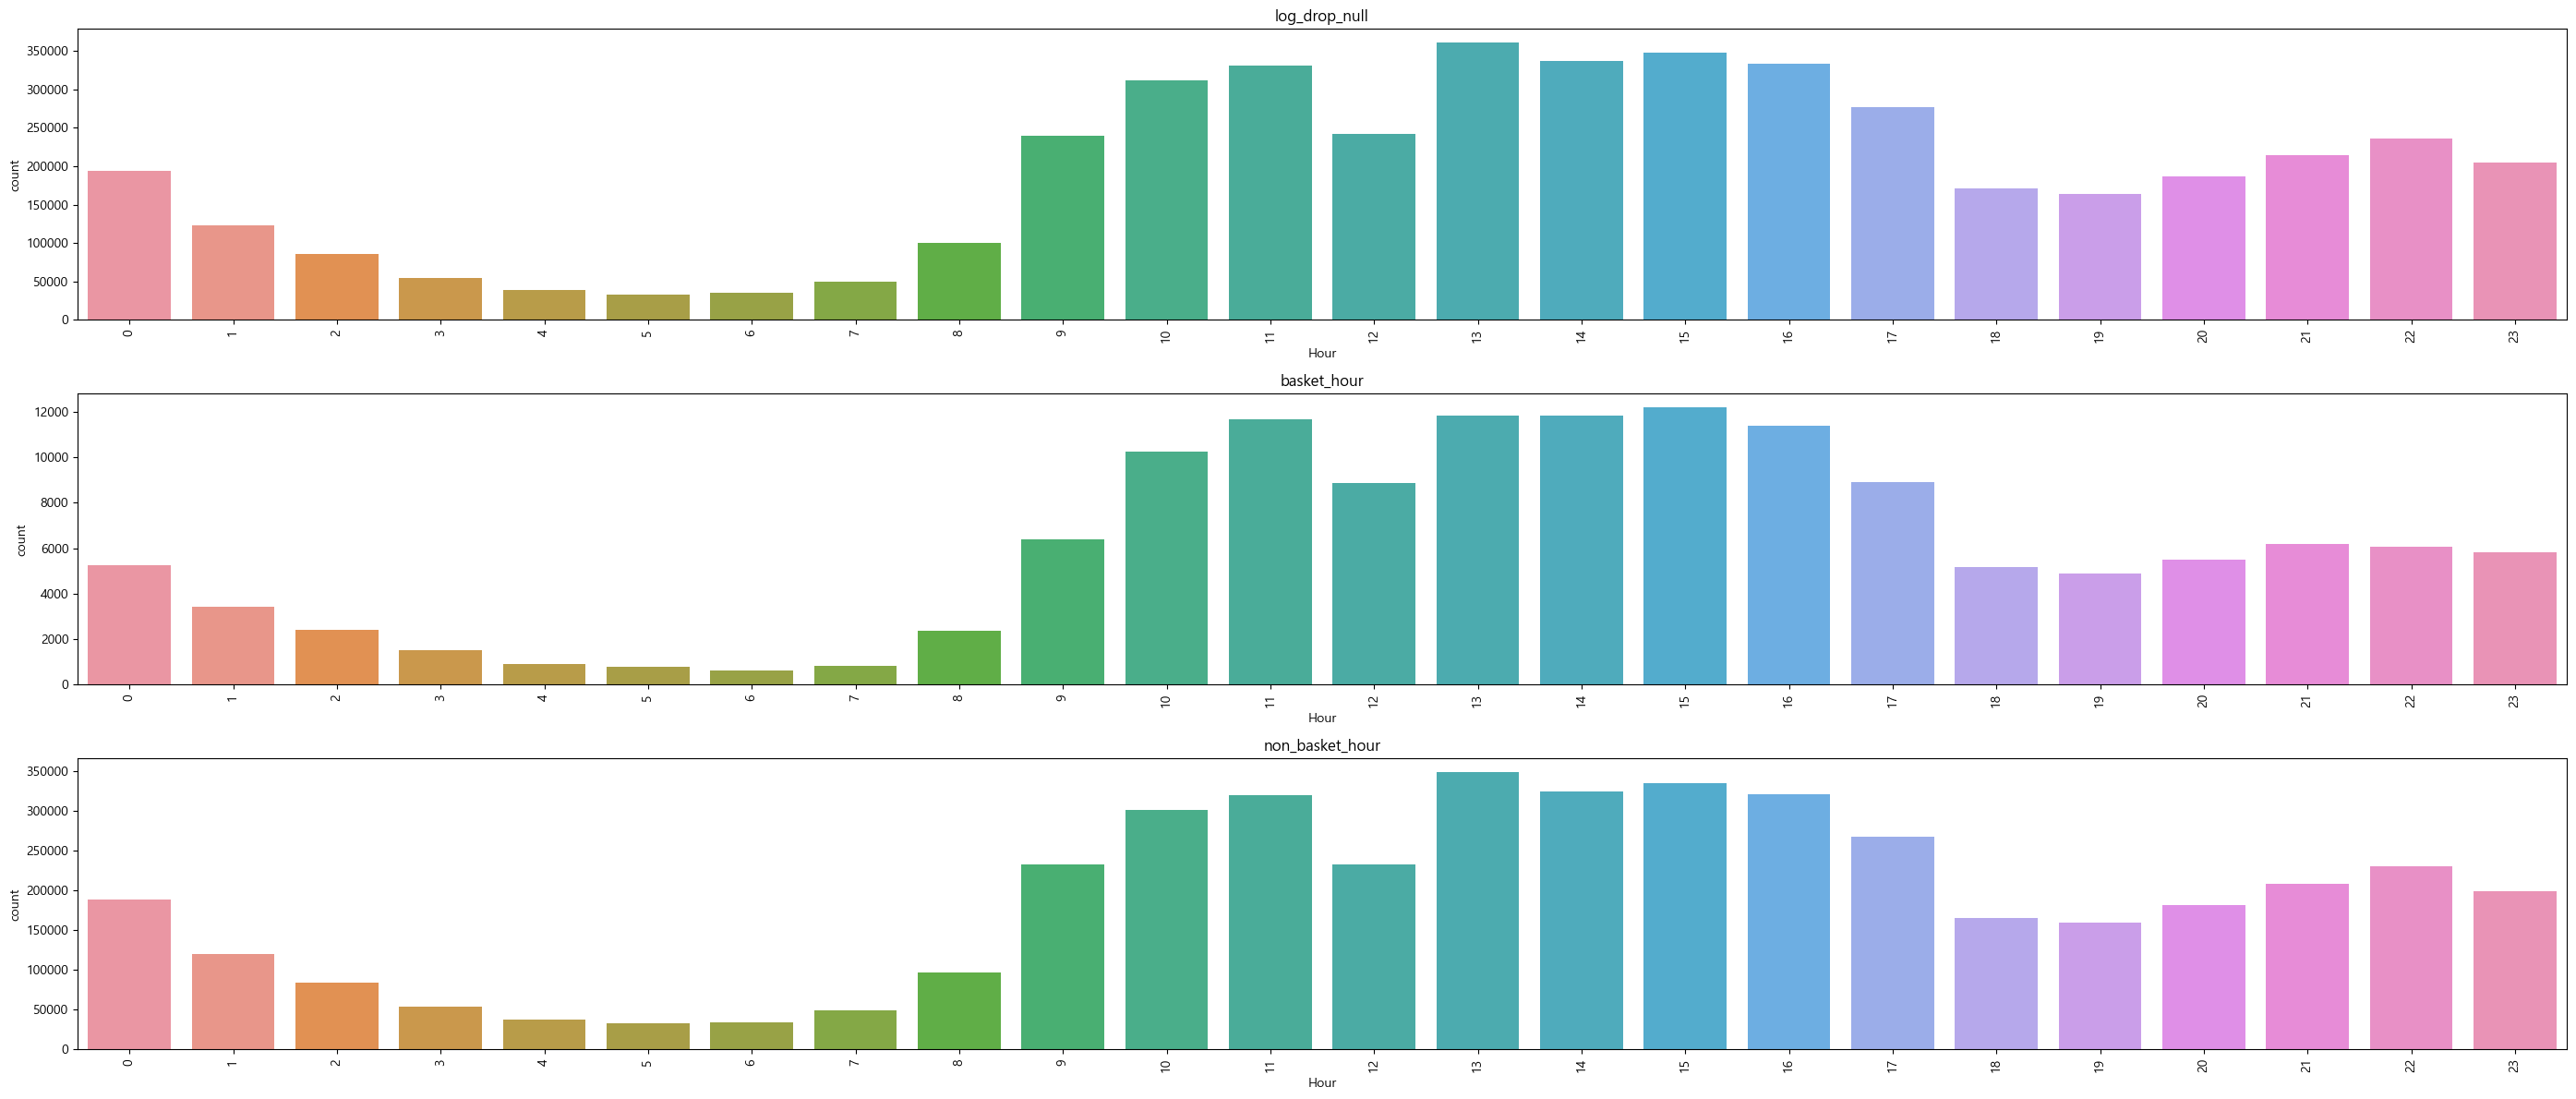

In [20]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함

# text  = 제목 : 시간대별 로그데이터


plt.figure(figsize=(28, 12))
# text =  Total Data
plt.subplot(3, 1, 1)                
display(log_drop_null["Hour"].value_counts(normalize=True))
sns.countplot(data=log_drop_null, x="Hour")
plt.title('log_drop_null')
plt.xticks(rotation=90)


plt.subplot(3, 1, 2)
# text = Basket Uid Data
display(basket_hour["Hour"].value_counts(normalize=True))
sns.countplot(data=basket_hour, x="Hour")
plt.title('basket_hour')
plt.xticks(rotation=90)


plt.subplot(3, 1, 3)  
# text = Non Basket Data 
display(non_basket_hour["Hour"].value_counts(normalize=True))
sns.countplot(data=non_basket_hour, x="Hour")
plt.title('non_basket_hour')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

In [123]:
# import seaborn as sns
sns.set_style("white")
sns.despine(top=True, right=True)
sns.set_context("poster", font_scale = .5)
sns.set_palette('asdasfas', 5)

ValueError: asdasfas is not a valid palette name

<Figure size 640x480 with 0 Axes>

Windows      6.522892e-01
Android      1.756621e-01
iOS          1.119223e-01
Mac OS X     5.765672e-02
Linux        1.858465e-03
Chrome OS    2.363489e-04
Other        2.301405e-04
CentOS       6.315483e-05
Ubuntu       4.602810e-05
Tizen        3.425347e-05
FreeBSD      6.422525e-07
Fedora       4.281683e-07
OpenBSD      2.140842e-07
Name: useragent_os, dtype: float64

Windows      7.674684e-01
Android      1.117415e-01
iOS          7.020231e-02
Mac OS X     4.871286e-02
Linux        1.468055e-03
Chrome OS    1.961608e-04
Other        1.106851e-04
CentOS       3.820802e-05
Ubuntu       3.545074e-05
Tizen        2.520942e-05
Fedora       7.877942e-07
FreeBSD      3.938971e-07
Name: useragent_os, dtype: float64

Windows      0.474668
Android      0.270808
iOS          0.171572
Mac OS X     0.079242
Linux        0.003115
Chrome OS    0.000220
Other        0.000172
Ubuntu       0.000096
Tizen        0.000055
CentOS       0.000052
Name: useragent_os, dtype: float64

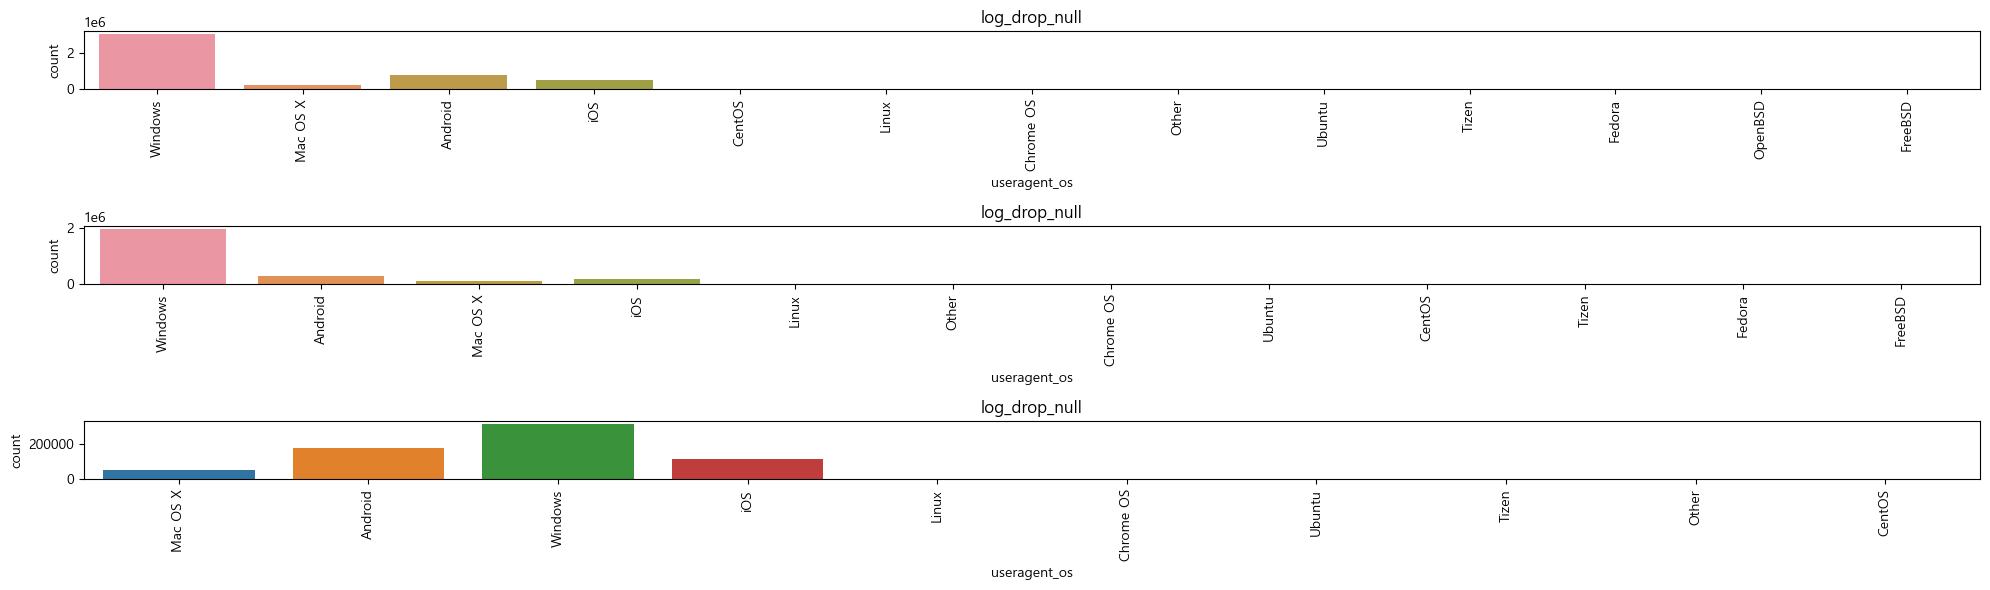

In [21]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# 전체 데이터 os 비중, 전체시간, 근무시간과, 자는시간 

# text = 제목 : 데이터 그룹별 OS 비중

plt.figure(figsize=(20, 6))
plt.subplot(3, 1, 1)
# text = Total Data 
display(log_drop_null["useragent_os"].value_counts(normalize=True))
sns.countplot(data=log_drop_null, x=log_drop_null['useragent_os'])
plt.title('log_drop_null')
plt.xticks(rotation=90)


plt.subplot(3, 1, 2)                
# text = Basket Data 
display(log_time1['useragent_os'].value_counts(normalize=True))
sns.countplot(data=log_time1, x=log_time1['useragent_os'])
plt.title('log_drop_null')
plt.xticks(rotation=90)

plt.subplot(3, 1, 3)                
# text = Non Basket Data 
display(log_time2['useragent_os'].value_counts(normalize=True))
sns.countplot(data=log_time2, x=log_time2['useragent_os'])
plt.title('log_drop_null')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Windows      0.899954
Mac OS X     0.092167
iOS          0.004001
Linux        0.002256
Android      0.001187
Chrome OS    0.000414
Ubuntu       0.000014
Tizen        0.000007
Name: useragent_os, dtype: float64

Windows      0.925649
Mac OS X     0.070080
iOS          0.002084
Linux        0.001209
Android      0.000863
Chrome OS    0.000115
Name: useragent_os, dtype: float64

Windows      0.844676
Mac OS X     0.136552
iOS          0.008638
Linux        0.007309
Android      0.002160
Chrome OS    0.000498
Ubuntu       0.000111
Tizen        0.000055
Name: useragent_os, dtype: float64

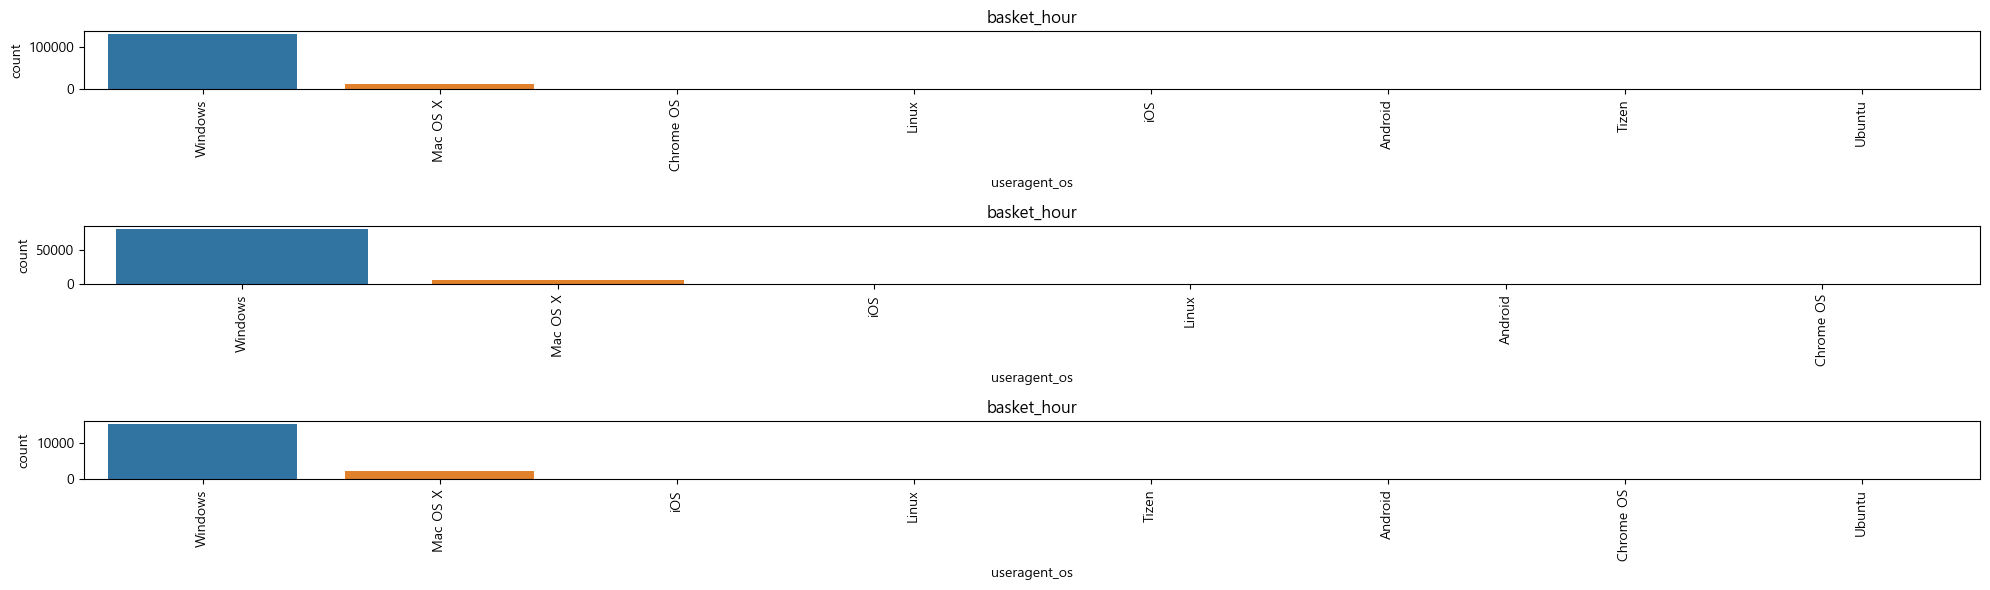

In [22]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# 바스켓 uid os 비중, 전체시간, 근무시간과, 자는시간 

# text  = 제목 : Basket Uid Data 시간대별 OS 비율

plt.figure(figsize=(20, 6))
# text  =전체시간
plt.subplot(3, 1, 1)
display(basket_hour["useragent_os"].value_counts(normalize=True))
sns.countplot(data=basket_hour, x=basket_hour['useragent_os'])
plt.title('basket_hour')
plt.xticks(rotation=90)


plt.subplot(3, 1, 2)                
# text  = 주요(근무)시간
display(basket_time1['useragent_os'].value_counts(normalize=True))
sns.countplot(data=basket_time1, x=basket_time1['useragent_os'])
plt.title('basket_hour')
plt.xticks(rotation=90)

plt.subplot(3, 1, 3)                
# text  = 자는시간
display(basket_time2['useragent_os'].value_counts(normalize=True))
sns.countplot(data=basket_time2, x=basket_time2['useragent_os'])
plt.title('basket_hour')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Windows      6.443574e-01
Android      1.812498e-01
iOS          1.153786e-01
Mac OS X     5.655148e-02
Linux        1.845737e-03
Other        2.375110e-04
Chrome OS    2.306619e-04
CentOS       6.517744e-05
Ubuntu       4.706032e-05
Tizen        3.512954e-05
FreeBSD      6.628214e-07
Fedora       4.418809e-07
OpenBSD      2.209405e-07
Name: useragent_os, dtype: float64

Windows      7.618648e-01
Android      1.156694e-01
iOS          7.261542e-02
Mac OS X     4.795593e-02
Linux        1.477236e-03
Chrome OS    1.990313e-04
Other        1.146061e-04
CentOS       3.956154e-05
Ubuntu       3.670659e-05
Tizen        2.610246e-05
Fedora       8.157019e-07
FreeBSD      4.078510e-07
Name: useragent_os, dtype: float64

Windows      0.464189
Android      0.278416
iOS          0.176186
Mac OS X     0.077619
Linux        0.002997
Chrome OS    0.000212
Other        0.000177
Ubuntu       0.000096
Tizen        0.000055
CentOS       0.000053
Name: useragent_os, dtype: float64

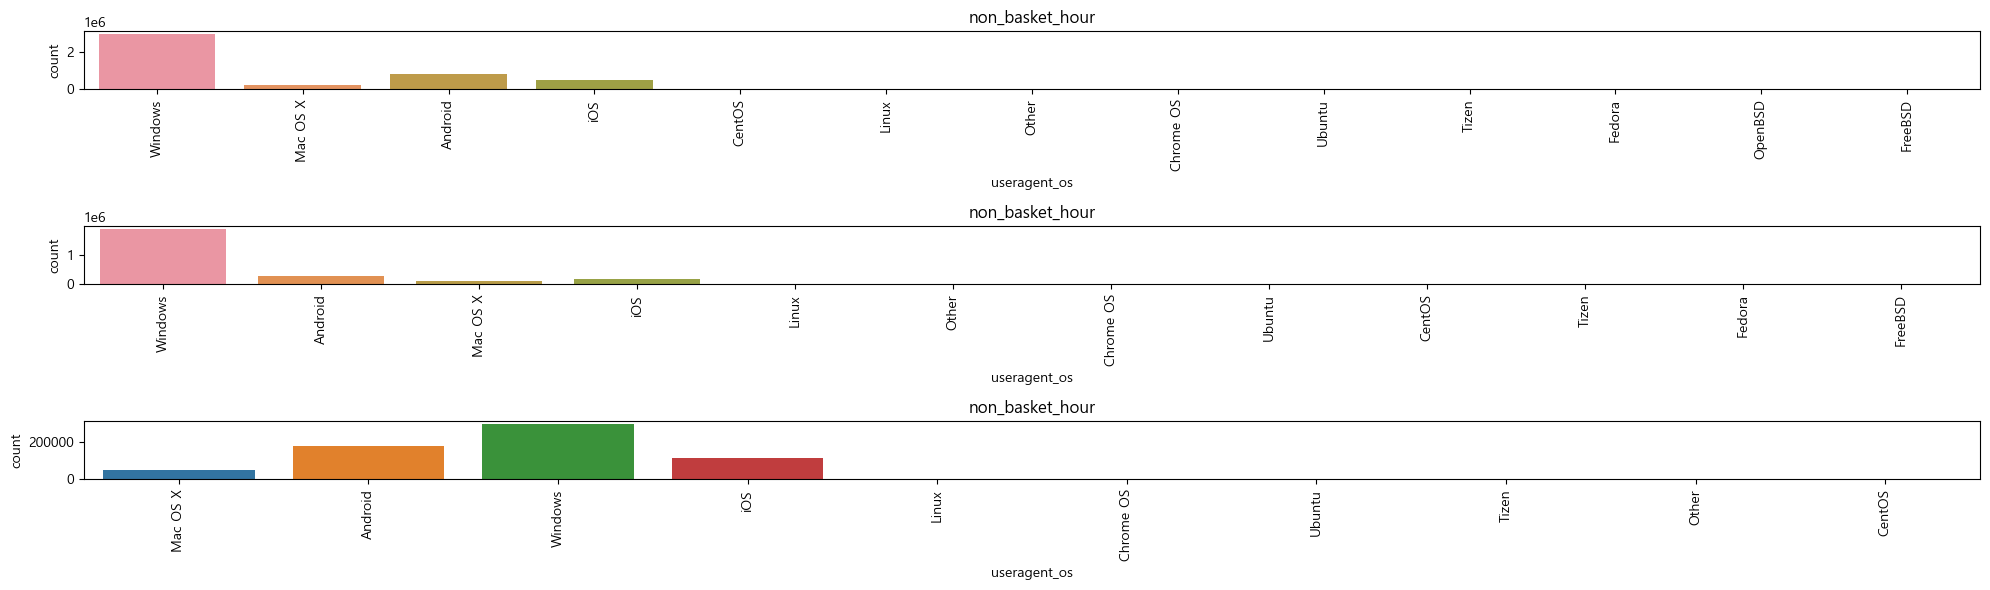

In [23]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# non 바스켓 uid os 비중, 전체시간, 근무시간과, 자는시간 


# text  = 제목 :  Non Basket Uid Data 시간대별 OS 비율

plt.figure(figsize=(20, 6))

# text  = 전체시간
plt.subplot(3, 1, 1)
display(non_basket_hour["useragent_os"].value_counts(normalize=True))
sns.countplot(data=non_basket_hour, x=non_basket_hour['useragent_os'])
plt.title('non_basket_hour')
plt.xticks(rotation=90)

# text  = 주요(근무)시간
plt.subplot(3, 1, 2)                
display(non_basket_time1['useragent_os'].value_counts(normalize=True))
sns.countplot(data=non_basket_time1, x=non_basket_time1['useragent_os'])
plt.title('non_basket_hour')
plt.xticks(rotation=90)

# text  = 자는시간
plt.subplot(3, 1, 3)                
display(non_basket_time2['useragent_os'].value_counts(normalize=True))
sns.countplot(data=non_basket_time2, x=non_basket_time2['useragent_os'])
plt.title('non_basket_hour')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [24]:
# 수치표현
# 전체 로그데이터 뷰타임 평균
# 평균과 중간값의 차이를 보여주기 위한 용도

# text = 전체 데이터 viewtime 평균
log_view_time = log_drop_null.loc[log_drop_null["viewtime"] > 0]
log_view_time['viewtime'].mean() / 1000

65.52303954670505

In [25]:
# 수치표현
# 전체 로그데이터 뷰타임 중간값

# text = 전체 데이터 viewtime 중간값
log_view_time = log_drop_null.loc[log_drop_null["viewtime"] > 0]
log_view_time['viewtime'].median() / 1000

17.985

(array([1]), [Text(0, 0, '')])

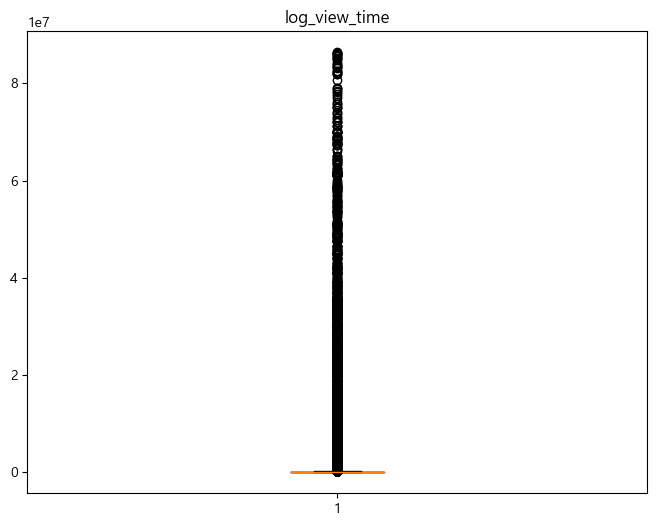

In [26]:
# 그래프표현
# 아웃라이어 값 확인
# text  = Viewtime boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(log_view_time['viewtime'])
plt.title('log_view_time')
plt.xticks()

In [27]:
log_view_time["time"] = np.where((log_view_time['Hour'] >= 13)&(log_view_time["Hour"].values <= 17) , "1","0" )

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\3940570260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
# 수치표현
# 전체 로그데이터 근무시간대 뷰타임 중간값

# text = 전체 데이터 주요(근무)시간대 viewtime 중간값
log_view_time_1 = log_view_time.loc[log_view_time["time"] == "1"]
log_view_time_1['viewtime'].median() / 1000

16.814

In [29]:
# 수치표현

# text = 전체 데이터 자는 시간대 viewtime 중간값
log_view_time_0 = log_view_time.loc[log_view_time["time"] == "0"]
log_view_time_0['viewtime'].median() / 1000

18.011

## Prophet timeseries

In [30]:
# column describe 
def descriptive_info(bidding):
    number_of_cells = bidding.count(axis=0, level=None, numeric_only=False)
    print('Total number of cells the datafile has: \n' + str(number_of_cells))
    print('\n')
    print('Printing descriptive statistics...\n\n', bidding.describe())

descriptive_info(bidding)

Total number of cells the datafile has: 
index              1337088
Impression         1337088
Click              1337088
Cost               1337088
Sum of AD rank     1337078
Bid                1337088
Price(PC)          1337088
Price(Mobile)      1337088
Delivery Fee       1337088
Category Name 1    1337088
Category Name 2    1337088
Category Name 3    1331221
Category Name 4     930132
date               1337088
dtype: int64


Printing descriptive statistics...

               index    Impression         Click          Cost  Sum of AD rank  \
count  1.337088e+06  1.337088e+06  1.337088e+06  1.337088e+06    1.337078e+06   
mean   5.167098e+06  4.412753e+01  7.189467e-01  1.800053e+02    1.138271e+01   
std    2.655813e+06  3.434510e+02  3.423456e+00  1.772706e+03    1.323231e+01   
min    2.578600e+04  0.000000e+00  0.000000e+00  0.000000e+00    1.000000e+00   
25%    3.300168e+06  3.000000e+00  0.000000e+00  0.000000e+00    3.706897e+00   
50%    4.637081e+06  1.000000e+01  0.000000

In [31]:
# bidding 날짜 datetime으로 만들기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

_trans_date_time(bidding)

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [32]:
bidding_drop_null = bidding.copy()
bidding_drop_null['Category Name 4'].fillna('null_cat4', inplace = True)
bidding_drop_null.dropna(axis = 0, inplace = True)
print(bidding_drop_null.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
dtype: int64


In [33]:
bid_data_click = bidding_drop_null[bidding_drop_null['Click'] != 0]
bid_data_click

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,null_cat4
2022-10-31,4158472,138,2,270.0,4.420290,240,129000,129000,0,가구/인테리어,아동/주니어가구,책장,null_cat4
2022-10-31,4159062,60,1,50.0,10.366667,50,699000,699000,0,가구/인테리어,아동/주니어가구,책상,null_cat4
2022-10-31,4159066,76,3,640.0,5.421053,250,149000,149000,0,가구/인테리어,아동/주니어가구,책상,null_cat4
2022-10-31,4159664,170,2,200.0,2.811765,230,359000,359000,-1,가구/인테리어,침실가구,침대,침대프레임
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2564155,5,1,190.0,14.800000,50,98900,98900,-1,가구/인테리어,침실가구,침대,침대프레임
2023-01-03,2564724,39,1,250.0,2.743590,500,6900,6900,3000,화장품/미용,바디케어,핸드케어,null_cat4
2023-01-03,2566230,85,2,860.0,1.611765,500,36800,36800,0,생활/건강,욕실용품,수건/타월,세면타월


In [34]:
bid_data_click["Year"] = bid_data_click.index.year 
bid_data_click["Quarter"] = bid_data_click.index.quarter
bid_data_click["Month"] = bid_data_click.index.month
bid_data_click["Week"] = bid_data_click.index.week
bid_data_click["Weekday"] = bid_data_click.index.weekday
bid_data_click["Day"] = bid_data_click.index.day
bid_data_click["Dayofyear"] = bid_data_click.index.dayofyear
bid_data_click["Date"] = pd.DatetimeIndex(bid_data_click.index).date

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2055812707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2055812707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2055812707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [35]:
date_list = list(set(bid_data_click['Date']))              
columns = ['ds', 'y']
bid_click_mean = pd.DataFrame(columns=columns)
for date in date_list:
    bid_mean = bid_data_click.loc[bid_data_click['Date'] == date]
    bid_click_mean = bid_click_mean.append(pd.DataFrame([[date, bid_mean['Click'].mean()]], columns=columns), ignore_index=True)
bid_click_mean

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\2543848358.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

,ds,y
0,2022-11-15,3.438988
1,2022-11-26,3.155380
2,2023-01-01,2.869497
3,2022-12-02,2.576375
4,2022-11-10,2.772468
5,2022-11-14,3.287535
6,2022-11-17,3.405805
7,2022-11-01,3.266426
8,2022-11-05,2.920715
9,2022-12-16,2.845628


In [36]:
train = bid_click_mean
train

,ds,y
0,2022-11-15,3.438988
1,2022-11-26,3.155380
2,2023-01-01,2.869497
3,2022-12-02,2.576375
4,2022-11-10,2.772468
5,2022-11-14,3.287535
6,2022-11-17,3.405805
7,2022-11-01,3.266426
8,2022-11-05,2.920715
9,2022-12-16,2.845628


In [37]:
prophet = Prophet()
prophet.fit(train)


# create a future data frame 
future = prophet.make_future_dataframe(periods=7, freq = 'D')
forecast = prophet.predict(future)

13:06:58 - cmdstanpy - INFO - Chain [1] start processing
13:06:59 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\bongkyun\AppData\Roaming\Python\Python39\site-packages\prophet\plot.py:194: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.


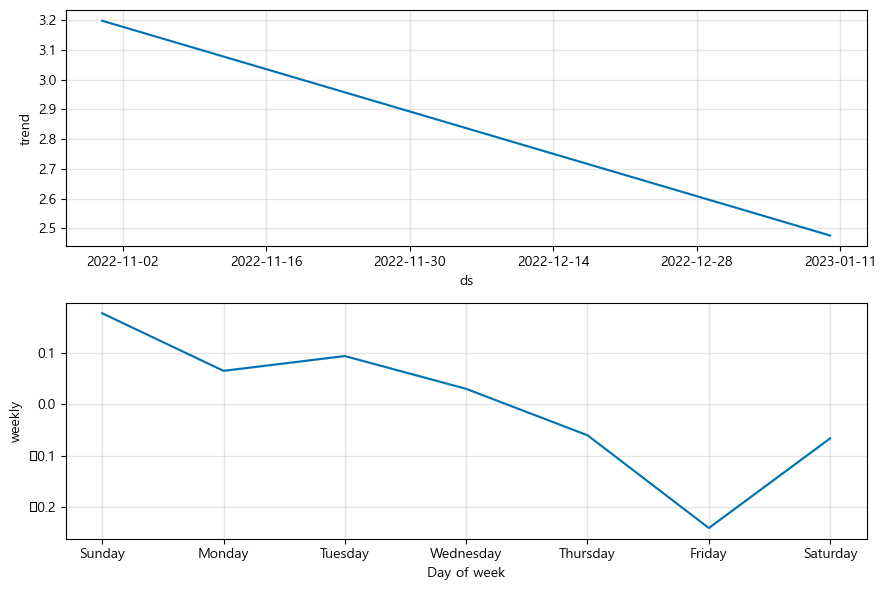

In [38]:
# 그래프 표현
# 클릭이 무슨요일의 많이 나타나는지 보여주는 용도

# text = 요일별 클릭
fig2 = prophet.plot_components(forecast)
plt.show()

# Basket Uid 별로 분석

In [39]:
# 전체 uid 개수
log_uid = list(set(log_drop_null['uid'].to_list()))
len(log_uid)

647910

In [40]:
# 바스켓을 한 uid 개수
log_uid_set = log_drop_null.loc[log_drop_null['action_type'] == 'Basket', 'uid']
log_uid_set = list(set(log_uid_set.to_list()))
len(log_uid_set)

34462

In [41]:
# 바스켓을 한 uid별로 데이터 프레임
basket_uid = log_drop_null[log_drop_null['uid'].isin(log_uid_set)]
basket_uid

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime,Hour,Minute,time_1,time_2
collect_time,,,,,,,,,,,,,,
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0,12,56,1,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0,17,54,1,0
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0,17,53,1,0
2022-12-29 09:13:14,6,Adwku2KoPCwAANbw,View,노하우,꾸미기팁,un_category,Gwanak-gu,Windows,100.0,37161,9,13,0,0
2022-12-29 15:50:12,12,Oxh70WOs80cAAJIx,View,생활용품,욕실용품,목욕·샤워용품,un_city_name,Windows,100.0,40015,15,50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28 18:17:56,5659522,Di7Ia2OrrcIADRhS,View,가구,서랍·수납장,수납장,Daegu,Windows,100.0,1096,18,17,0,0
2022-12-29 14:48:41,5659529,tEHACmOs7eIABtWy,Highlight,패브릭,커튼·부자재,가리개커튼,Suncheon,Windows,0.0,0,14,48,1,0
2022-12-28 22:14:15,5659532,cLkIu2OXMw8AA9Dr,Basket,주방용품,주방수납·정리,홀더,Haman,Windows,0.0,0,22,14,0,1


In [42]:
# 바스켓 uid 컬럼별 특징 찾아보기
for col in list(basket_uid.columns):
    print(col)
    print(basket_uid[col].value_counts(normalize=True))
    print('\n')

Unnamed: 0
1          6.258347e-07
3773826    6.258347e-07
3773917    6.258347e-07
3773910    6.258347e-07
3773904    6.258347e-07
               ...     
1887806    6.258347e-07
1887805    6.258347e-07
1887804    6.258347e-07
1887802    6.258347e-07
5659537    6.258347e-07
Name: Unnamed: 0, Length: 1597866, dtype: float64


uid
un_name             8.268591e-02
doMt0mJwbdMAB+YD    8.359274e-03
doMt1GOIBUUAAESl    4.417141e-03
eZapCGOX9s4ABeVy    3.055951e-03
eZapCGOZHH0ACCny    2.007678e-03
                        ...     
cNjOMmMild4AA/dO    6.258347e-07
0mMo42M6J/cABXUX    6.258347e-07
0+IcwmEogCUAChBK    6.258347e-07
dH1vC19LmYMACsJ6    6.258347e-07
0l0uUmEA4EoABX7b    6.258347e-07
Name: uid, Length: 34462, dtype: float64


action_type
View         0.805444
Basket       0.090717
Highlight    0.087770
Copy         0.011888
SINF         0.004181
Name: action_type, dtype: float64


category1
가구        3.441490e-01
패브릭       1.325943e-01
주방용품      1.196853e-01
데코·식물     7.812232e-02
가전·

In [43]:
# 전체 데이터 컬럼별 특징 찾아보기
for col in list(log_drop_null.columns):
    print(col)
    print(log_drop_null[col].value_counts(normalize=True))
    print('\n')

Unnamed: 0
0          2.140842e-07
3775256    2.140842e-07
3775263    2.140842e-07
3775262    2.140842e-07
3775260    2.140842e-07
               ...     
1888379    2.140842e-07
1888380    2.140842e-07
1888381    2.140842e-07
1888382    2.140842e-07
5659540    2.140842e-07
Name: Unnamed: 0, Length: 4671060, dtype: float64


uid
un_name             2.828501e-02
Ou7/0GNRCGsADSX9    3.163094e-03
doMt0mJwbdMAB+YD    2.859522e-03
doMt1GJwbywACgRw    2.034442e-03
Ou7/0GMEXxcAAgZn    1.932110e-03
                        ...     
J3cZkGKxvaoAB7EM    2.140842e-07
2pPbcmNODGUAAB4n    2.140842e-07
0zBZsGB37/MACmfd    2.140842e-07
dW8c/GIn4k4ACdLF    2.140842e-07
dusqTmOtPa8AB46D    2.140842e-07
Name: uid, Length: 647910, dtype: float64


action_type
View         0.862716
Highlight    0.082997
Basket       0.031032
Copy         0.018725
SINF         0.004530
Name: action_type, dtype: float64


category1
가구        3.566225e-01
패브릭       1.164648e-01
주방용품      9.764721e-02
가전·디지털    9.194872e-02
데코

In [44]:
# 수치표현
# 바스켓 uid 전체 데이터 뷰타임 중간값

# text = Basket Uid Data Viewtime 중간값
basket_viewtime = basket_uid.loc[basket_uid["viewtime"] > 0]
basket_viewtime.viewtime.median() / 1000

18.017

In [45]:
basket_uid[basket_uid['useragent_os'].str.contains('Windows|Android|iOS|Mac OS X')]

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime,Hour,Minute,time_1,time_2
collect_time,,,,,,,,,,,,,,
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0,12,56,1,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0,17,54,1,0
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0,17,53,1,0
2022-12-29 09:13:14,6,Adwku2KoPCwAANbw,View,노하우,꾸미기팁,un_category,Gwanak-gu,Windows,100.0,37161,9,13,0,0
2022-12-29 15:50:12,12,Oxh70WOs80cAAJIx,View,생활용품,욕실용품,목욕·샤워용품,un_city_name,Windows,100.0,40015,15,50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28 18:17:56,5659522,Di7Ia2OrrcIADRhS,View,가구,서랍·수납장,수납장,Daegu,Windows,100.0,1096,18,17,0,0
2022-12-29 14:48:41,5659529,tEHACmOs7eIABtWy,Highlight,패브릭,커튼·부자재,가리개커튼,Suncheon,Windows,0.0,0,14,48,1,0
2022-12-28 22:14:15,5659532,cLkIu2OXMw8AA9Dr,Basket,주방용품,주방수납·정리,홀더,Haman,Windows,0.0,0,22,14,0,1


In [46]:
basket_uid["useragent_os"] = np.where((basket_uid['useragent_os'] == 'Android')|(basket_uid["useragent_os"] == 'iOS') , "1","0" )

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\1575835986.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
# 수치표현
# 바스켓 uid 모바일 데이터 뷰타임 중간값

# text = Basket Uid  Mobile Data Viewtime 중간값
basket_mobile = basket_uid[basket_uid['useragent_os'] == '1']
basket_mobile = basket_mobile[basket_mobile['viewtime'] > 0]
basket_mobile.viewtime.median() / 1000

14.008

In [48]:
# 수치표현
# 바스켓 uid 데스크탑 데이터 중간값

# text = Basket Uid Desktop Viewtime 중간값
basket_desktop = basket_uid[basket_uid['useragent_os'] == '0']
basket_desktop = basket_desktop[basket_desktop['viewtime'] > 0]
basket_desktop.viewtime.median() / 1000

18.018

# Non - Basket Uid 별로 분석

In [49]:
non_uid_set = log_drop_null.loc[log_drop_null['action_type'] != 'Basket', 'uid']
non_uid_set = list(set(non_uid_set.to_list()))
len(non_uid_set)

647728

In [50]:
non_basket_uid = log_drop_null[log_drop_null['uid'].isin(non_uid_set)]
non_basket_uid

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime,Hour,Minute,time_1,time_2
collect_time,,,,,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033,17,29,1,0
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0,12,56,1,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0,17,54,1,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238,18,45,0,0
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0,17,53,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 12:45:14,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,Gangnam-gu,Android,100.0,6054,12,45,1,0
2022-12-28 15:40:29,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,Songpa-gu,Windows,100.0,10006,15,40,1,0
2022-12-28 14:30:09,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,Jinju,Windows,0.0,0,14,30,1,0


In [51]:
for col in list(non_basket_uid.columns):
    print(col)
    print(non_basket_uid[col].value_counts(normalize=True))
    print('\n')

Unnamed: 0
0          2.140939e-07
3775251    2.140939e-07
3775258    2.140939e-07
3775257    2.140939e-07
3775256    2.140939e-07
               ...     
1888385    2.140939e-07
1888386    2.140939e-07
1888387    2.140939e-07
1888388    2.140939e-07
5659540    2.140939e-07
Name: Unnamed: 0, Length: 4670848, dtype: float64


uid
un_name             2.828630e-02
Ou7/0GNRCGsADSX9    3.163237e-03
doMt0mJwbdMAB+YD    2.859652e-03
doMt1GJwbywACgRw    2.034534e-03
Ou7/0GMEXxcAAgZn    1.932197e-03
                        ...     
3u6SQGOqu5cAAYz0    2.140939e-07
dusE7GMxlRUACC16    2.140939e-07
e9Ukj2OZM2gAA9h9    2.140939e-07
r9O412OnRp0AA4LZ    2.140939e-07
dusqTmOtPa8AB46D    2.140939e-07
Name: uid, Length: 647728, dtype: float64


action_type
View         0.862755
Highlight    0.083000
Basket       0.030988
Copy         0.018726
SINF         0.004530
Name: action_type, dtype: float64


category1
가구        3.566286e-01
패브릭       1.164632e-01
주방용품      9.764544e-02
가전·디지털    9.194926e-02
데코

In [52]:
# 수치표현
# non 바스켓 uid 데이터 뷰타임 중간값

# text =  Non Basket Uid Data Viewtime 중간값
non_basket_viewtime = non_basket_uid.loc[non_basket_uid["viewtime"] > 0]
non_basket_viewtime.viewtime.median() / 1000

17.985

In [53]:
non_basket_uid[non_basket_uid['useragent_os'].str.contains('Windows|Android|iOS|Mac OS X')]

,Unnamed: 0,uid,action_type,category1,category2,category3,geoip_city_name,useragent_os,viewrate,viewtime,Hour,Minute,time_1,time_2
collect_time,,,,,,,,,,,,,,
2022-12-29 17:29:02,0,avpKyWMn/xEADNlb,View,주방용품,그릇·홈세트,식판·나눔접시,Seongnam-si,Windows,100.0,80033,17,29,1,0
2022-12-29 12:56:38,1,0+5vEmGkOuAAB5j2,Basket,패브릭,매트,주방·다용도매트,Yongin-si,Windows,0.0,0,12,56,1,0
2022-12-29 17:54:30,3,dC9Fl2Ly9lcADrTn,Highlight,데코·식물,플라워·식물,화병·화분,Gwangmyeong-si,Windows,0.0,0,17,54,1,0
2022-12-29 18:45:05,4,09gKcGLg0I8ACyQy,View,가구,진열장·책장,책장,Jongno-gu,Mac OS X,100.0,1238,18,45,0,0
2022-12-29 17:53:11,5,091fXGIDYFEABcpA,Basket,수납·정리,화장대·테이블정리,티슈커버·케이스,Incheon,Windows,0.0,0,17,53,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 12:45:14,5659533,3yfy5mOZpbYAAMpw,View,가전·디지털,주방가전,오븐·전자레인지,Gangnam-gu,Android,100.0,6054,12,45,1,0
2022-12-28 15:40:29,5659534,qE73wWOr1C8ABhBw,View,캠핑용품,캠핑생활용품,기타캠핑생활용품,Songpa-gu,Windows,100.0,10006,15,40,1,0
2022-12-28 14:30:09,5659537,PVMstmNg4I4ADq9R,Basket,가구,진열장·책장,책장,Jinju,Windows,0.0,0,14,30,1,0


In [54]:
non_basket_uid["useragent_os"] = np.where((non_basket_uid['useragent_os'] == 'Android')|(non_basket_uid["useragent_os"] == 'iOS') , "1","0" )

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\3357319109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
# 수치표현
# non 바스켓 uid 데이터 모바일 중간값

# text = Non Basket Uid Mobile Data Viewtime 중간값
non_basket_mobile = non_basket_uid[non_basket_uid['useragent_os'] == '1']
non_basket_mobile = non_basket_mobile[non_basket_mobile['viewtime'] > 0]
non_basket_mobile.viewtime.median() / 1000

18.008

In [56]:
# 수치표현
# non 바스켓 uid 데이터 데스크탑 중간값

# text = Non Basket Uid Desktop Data Viewtime 중간값
non_basket_desktop = non_basket_uid[non_basket_uid['useragent_os'] == '0']
non_basket_desktop = non_basket_desktop[non_basket_desktop['viewtime'] > 0]
non_basket_desktop.viewtime.median() / 1000

17.432

# 카이제곱검정

In [57]:
# 수치표현
# P-value 0.05보다 작으면 두집단간의 차이가 있다. 0.05보다 크면 두집간간의 유의미한 차이가 없다

# 모바일과 데스크탑중 바스켓의 비율

log_drop_null = log_drop_null[log_drop_null['useragent_os'].str.contains('Windows|Android|iOS|Mac OS X')]
# 윈도우, 안드로이드, ios, mac 만 남기고 나머지 drop


log_drop_null["useragent_os"] = np.where((log_drop_null['useragent_os'] == 'Android')|
                                         (log_drop_null["useragent_os"] == 'iOS') , "1","0" )

# 모바일 (안드로이드, ios)은 1, 나머지는 0


log_drop_null["viewrate"] = np.where((log_drop_null['viewrate'] != 0), "1","0" )

# 뷰레이트는 혹시나해서?


log_basket = log_drop_null[log_drop_null['useragent_os']=='0'][['viewrate']]
log_non_basket = log_drop_null[log_drop_null['useragent_os']=='1'][['viewrate']]
# log_basket = log_drop_null[log_drop_null['useragent_os']=='0']
# log_non_basket = log_drop_null[log_drop_null['useragent_os']=='1']

total_basket = pd.concat([pd.get_dummies(log_basket),
                          log_drop_null[log_drop_null['useragent_os']=='0']
                          [['action_type']]],axis=1)

total_non_basket = pd.concat([pd.get_dummies(log_non_basket),
                              log_drop_null[log_drop_null['useragent_os']=='1']
                              [['action_type']]],axis=1)


a_0 = total_basket[total_basket['action_type']=='Basket'].shape[0]
a_1 = total_basket[total_basket['action_type']!='Basket'].shape[0]
b_0 = total_non_basket[total_non_basket['action_type']=='Basket'].shape[0]
b_1 = total_non_basket[total_non_basket['action_type']!='Basket'].shape[0]

dataset_chi = [[a_0, a_1], [b_0, b_1]]
pval = stats.chi2_contingency(dataset_chi)[1]
print('p-value : ',pval)

C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\3974369826.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\bongkyun\AppData\Local\Temp\ipykernel_10892\3974369826.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


p-value :  0.0


# 발표정리

### 시간대별 log데이터

In [ ]:
bidding = bidding_df.copy()

13    359719
15    346852
14    335575
16    332200
11    330366
10    311526
17    276569
12    241167
9     238898
22    235429
21    213960
23    203938
0     193588
20    186205
18    170439
19    163541
1     122983
8      99522
2      85846
3      54777
7      49611
4      38645
6      35091
5      33077
Name: Hour, dtype: int64

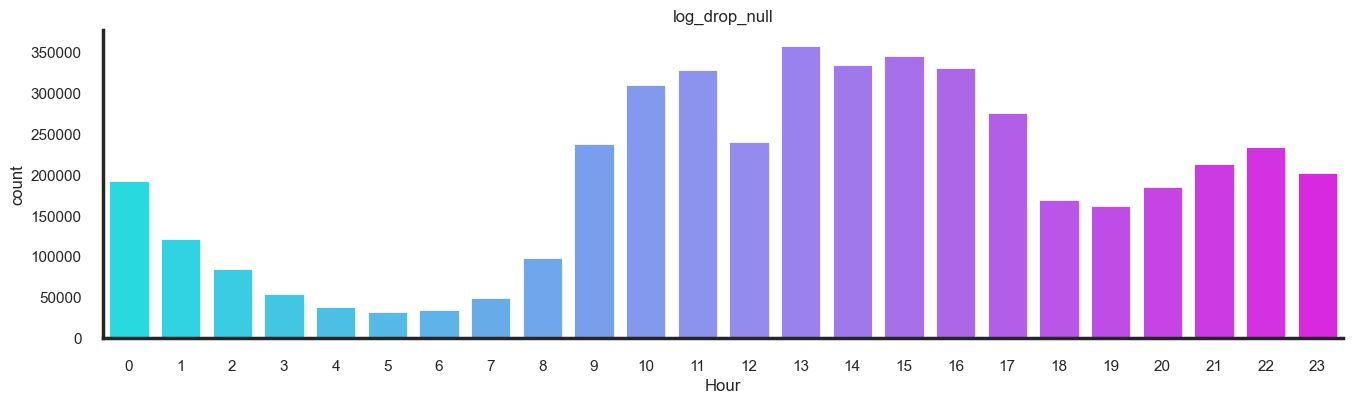

In [132]:
plt.figure(figsize=(16, 4))
display(log_drop_null["Hour"].value_counts(normalize=True))
sns.countplot(data=log_drop_null, x="Hour", palette='cool')
# sns.set_palette('Paired', 9)
plt.title('log_drop_null')
plt.xticks()
sns.despine()

13    359719
15    346852
14    335575
16    332200
11    330366
10    311526
17    276569
12    241167
9     238898
22    235429
21    213960
23    203938
0     193588
20    186205
18    170439
19    163541
1     122983
8      99522
2      85846
3      54777
7      49611
4      38645
6      35091
5      33077
Name: Hour, dtype: int64

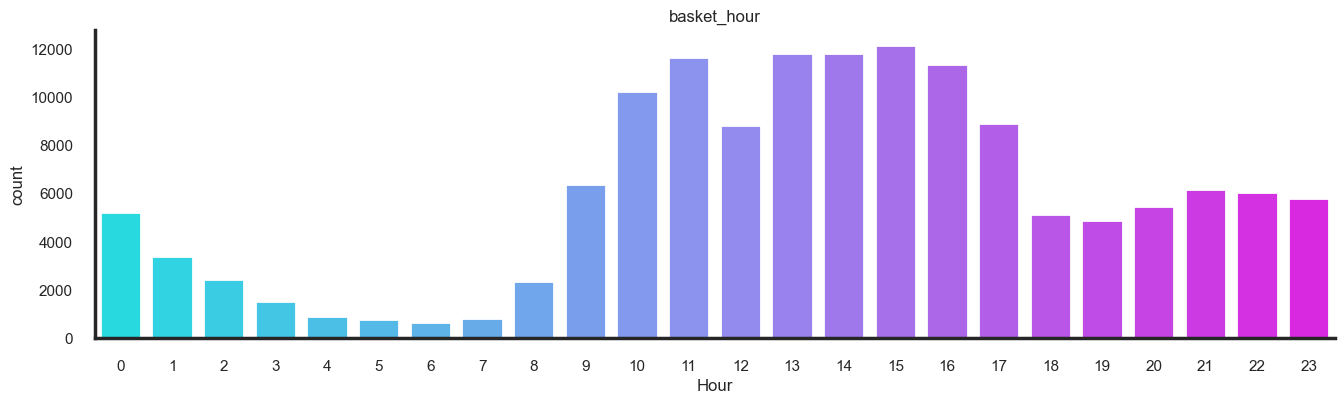

In [133]:
plt.figure(figsize=(16, 4))
display(log_drop_null["Hour"].value_counts(normalize=True))
sns.countplot(data=basket_hour, x="Hour", palette='cool')
plt.title('basket_hour')
plt.xticks()
sns.despine()

13    359719
15    346852
14    335575
16    332200
11    330366
10    311526
17    276569
12    241167
9     238898
22    235429
21    213960
23    203938
0     193588
20    186205
18    170439
19    163541
1     122983
8      99522
2      85846
3      54777
7      49611
4      38645
6      35091
5      33077
Name: Hour, dtype: int64

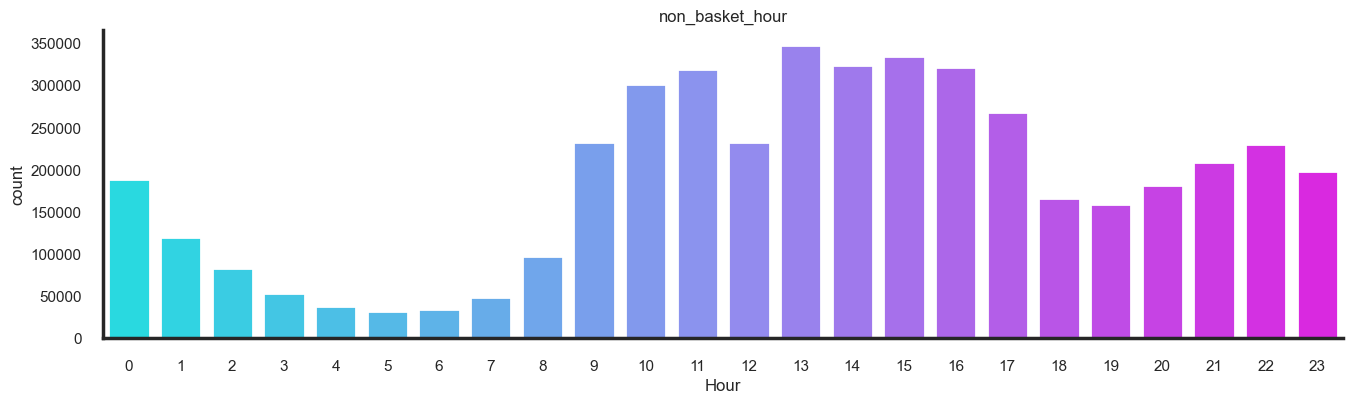

In [134]:
plt.figure(figsize=(16, 4))
display(log_drop_null["Hour"].value_counts(normalize=True))
sns.countplot(data=non_basket_hour, x="Hour", palette='cool')
plt.title('non_basket_hour')
plt.xticks()
sns.despine()

### 데이터 그룹별 os

0    0.711704
1    0.288296
Name: useragent_os, dtype: float64

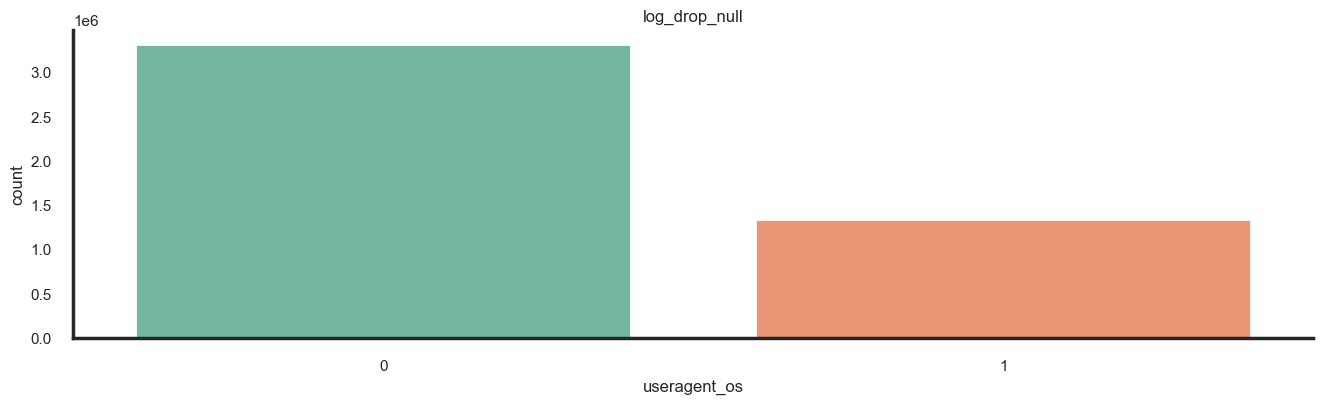

In [137]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# 전체 데이터 os 비중, 전체시간, 근무시간과, 자는시간 

# text = 제목 : 데이터 그룹별 OS 비중

plt.figure(figsize=(16, 4))
display(log_drop_null["useragent_os"].value_counts(normalize=True))
sns.countplot(data=log_drop_null, x="useragent_os", palette='Set2')
plt.title('log_drop_null')
plt.xticks()
sns.despine()

In [ ]:
# 그래프표현 수치표현
# 그래프도 나와야하지만 비중데이터도 같이 보여줘야함
# 전체 데이터 os 비중, 전체시간, 근무시간과, 자는시간 

# text = 제목 : 데이터 그룹별 OS 비중

plt.figure(figsize=(20, 6))
plt.subplot(3, 1, 1)
# text = Total Data 
display(log_drop_null["useragent_os"].value_counts(normalize=True))
sns.countplot(data=log_drop_null, x=log_drop_null['useragent_os'])
plt.title('log_drop_null')
plt.xticks(rotation=90)


plt.subplot(3, 1, 2)                
# text = Basket Data 
display(log_time1['useragent_os'].value_counts(normalize=True))
sns.countplot(data=log_time1, x=log_time1['useragent_os'])
plt.title('log_drop_null')
plt.xticks(rotation=90)

plt.subplot(3, 1, 3)                
# text = Non Basket Data 
display(log_time2['useragent_os'].value_counts(normalize=True))
sns.countplot(data=log_time2, x=log_time2['useragent_os'])
plt.title('log_drop_null')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()